In [ ]:
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
m1 = torch.tensor([5.,0.])
m2 = torch.tensor([0., 2.5])
t = torch.tensor([.1])
dt = 0.01
sigma = torch.tensor([3.1])
min_val = -6
max_val = 6

In [55]:
def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))

def compute_S_i_t(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t

In [44]:
def get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False, omega=None):
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    xx, yy = torch.meshgrid(
    [torch.linspace(min, max, steps=n)]*2, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1).reshape(-1, 2)

    conc = []
    for inp_ in inp:
        conc.append(score_func(inp_, t, m1, m2, Gamma_t, label=label, omega=omega))

    conc = torch.stack(conc).reshape(n, n, 2).detach().numpy()
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        plt.figure(figsize=(12, 12))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            plt.scatter(plots[0], plots[1], color='r', s=100)
        plt.show()
    return inp, conc

In [45]:
def generate_gif(gifname, score_func, m1, m2, dt, sigma, min_val, max_val, label=None, omega=None):
    images = []

    t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
    for t_value in tqdm(t_values):
        t = torch.tensor([t_value])
        inp, conc = get_vf(m1, m2, score_func, t, dt, sigma, n=25, min=min_val, max=max_val, label=label, omega=omega)

        plt.figure()
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            plt.scatter(plots[0], plots[1], color='r', s=100)
        plt.title(f't = {t_value:.2f}')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        

        plt_path = f'temp_plots/temp_{t_value:.2f}.png'
        plt.savefig(plt_path)
        plt.close()
        

        images.append(imageio.imread(plt_path))

    imageio.mimsave('gifs/'+gifname+'.gif', images, duration=0.05)

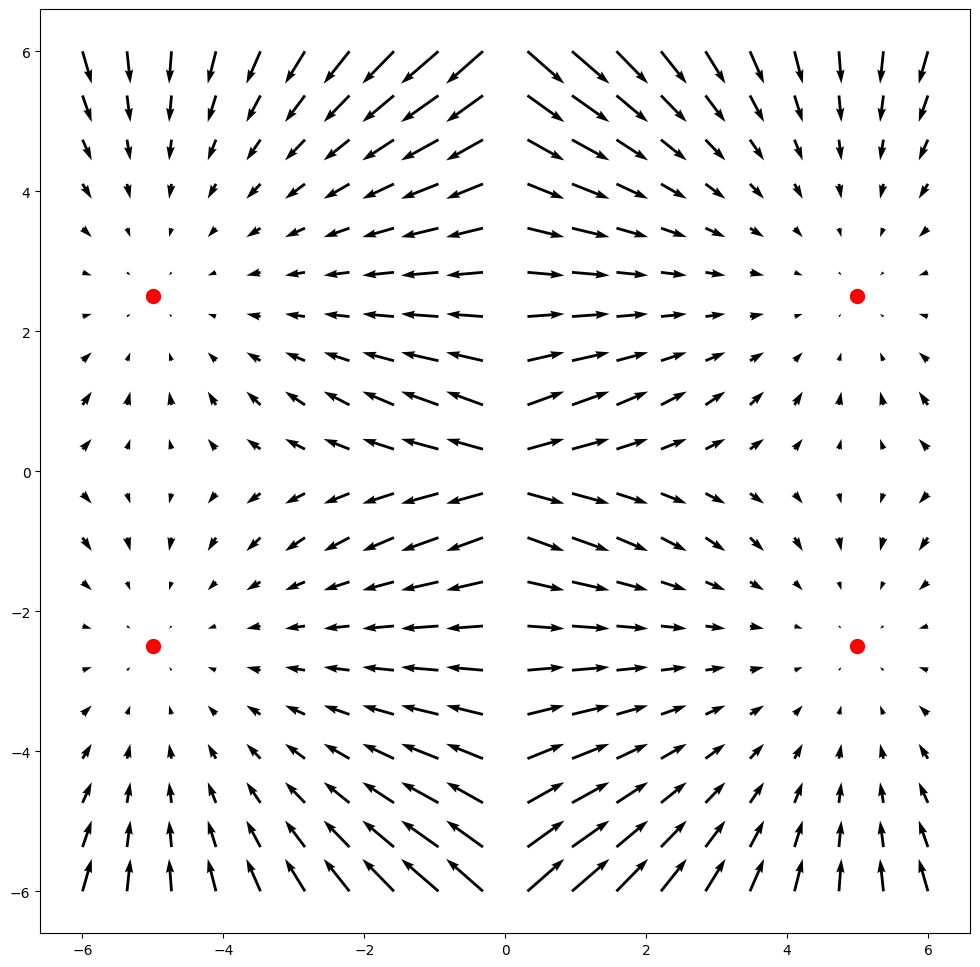

In [8]:
inp, conc = get_vf(m1, m2, compute_S_i_t, t, dt, sigma, n=20, min=-6, max=6, plot=True)


In [10]:
generate_gif('uncond_score', compute_S_i_t, m1, m2, dt, sigma, min_val, max_val)

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


## Only CFG part (true score)

In [51]:
def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x +((2*(label<2)-1) * m1 + (2*(label%2)-1) * m2) * torch.exp(-t)) / Gamma_t
    return score

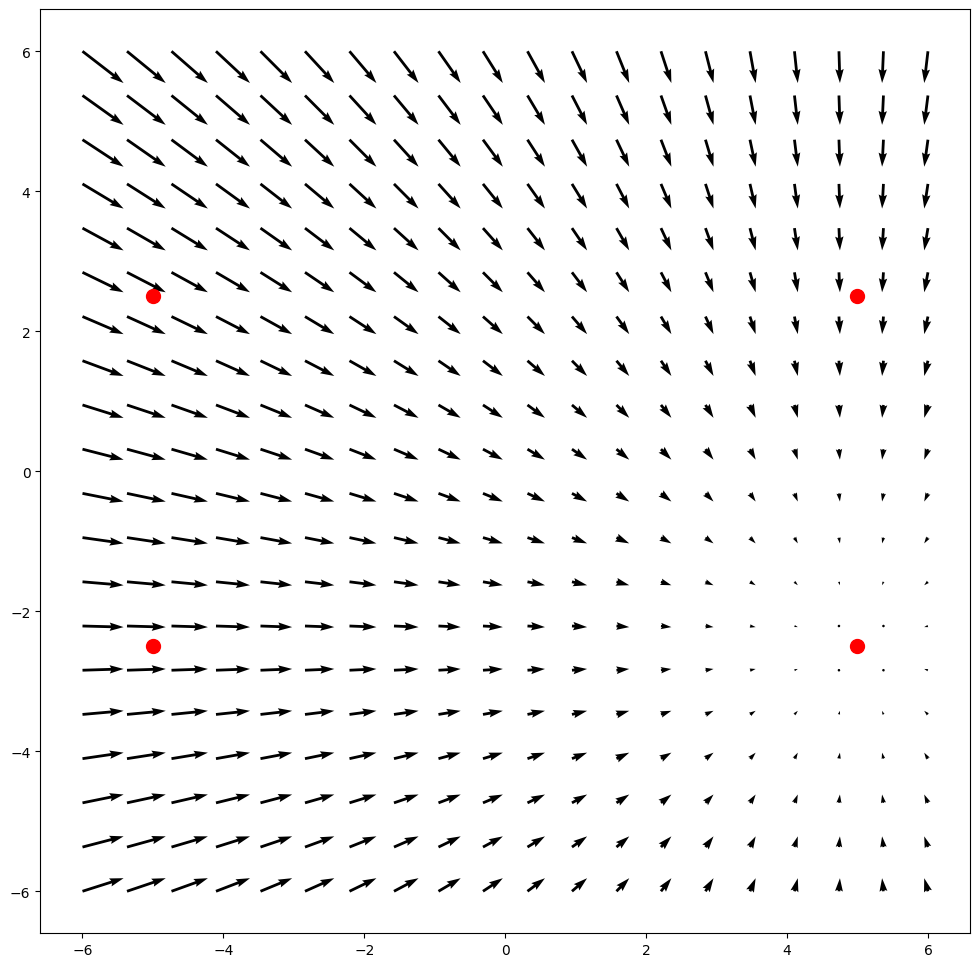

In [52]:
inp, conc = get_vf(m1, m2, cond_score, t, dt, sigma, n=20, min=-6, max=6, plot=True, label=0)

In [17]:
generate_gif('cond_score', cond_score, m1, m2, dt, sigma, min_val, max_val, label=0)

100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


# CFG

In [46]:
def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score = compute_S_i_t(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score

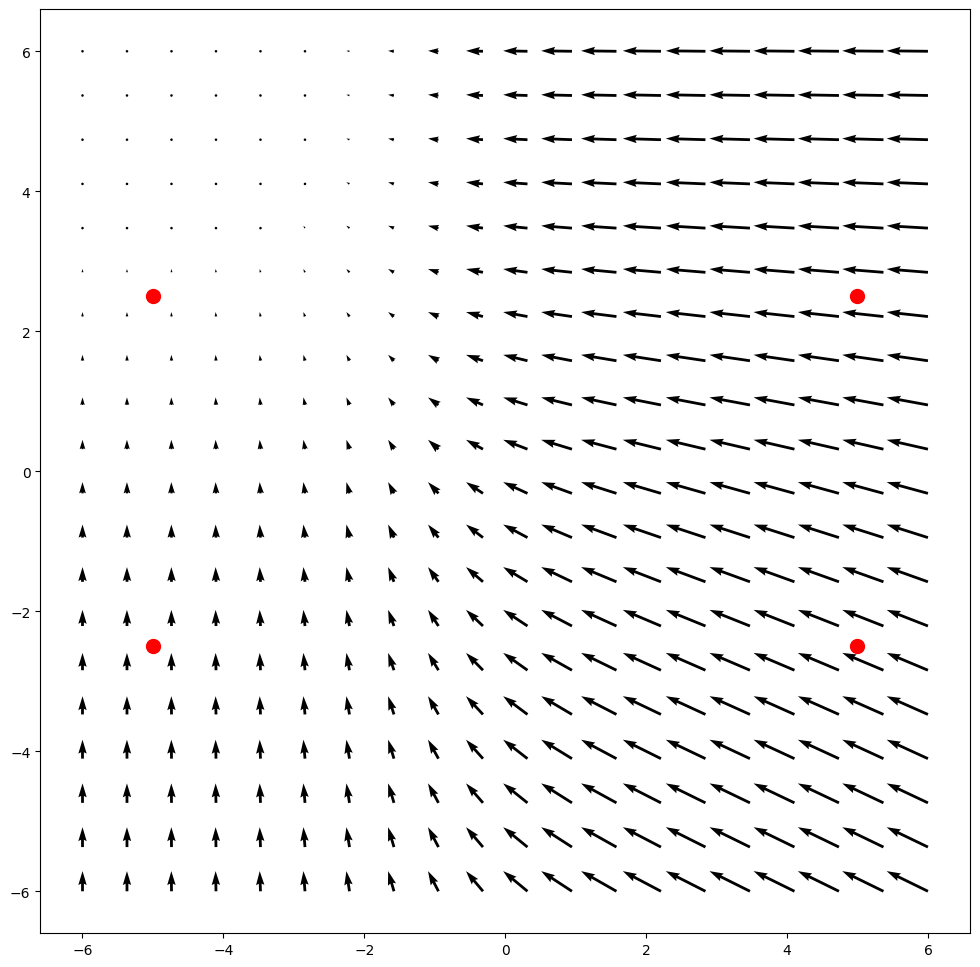

In [56]:
inp, conc = get_vf(m1, m2, cfg, t, dt, sigma, omega=100., n=20, min=-6, max=6, plot=True, label=3)

In [33]:
generate_gif('cfg_score', cfg, m1, m2, dt, sigma, min_val, max_val, label=0, omega=1.5)

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


## All three

In [13]:
def get_all_three(m1_, m2_, t, dt, sigma, omega, n=10, min=-5, max=5, label=0, plot=False):
    m1 = torch.tensor([m1_,0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)

    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))

    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1+omega)*conc1 - omega*conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
        for ax, c in zip(axes, [conc1, conc2, conc]):
            # for a specific t value rounded to two digits
            ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
            ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
            ax.scatter(m1_, m2_, color='b', s=100)
            ax.scatter(m1_, -m2_, color='r', s=100, label='Chosen class')
            ax.scatter(-m1_, m2_, color='b', s=100)
            ax.scatter(-m1_, -m2_, color='b', s=100)
            ax.legend()
        plt.show()
    return inp, conc

In [14]:
def get_all_three(m1_, m2_, t, dt, sigma, omega, n=10, min=-5, max=5, label=1, plot=False):
    m1 = torch.tensor([m1_, 0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2 * torch.exp(-2 * t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)
    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))
    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1 + omega) * conc1 - omega * conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
        for ax, c in zip(axes, [conc1, conc2, conc]):
            ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
            ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
            ax.scatter(m1_, m2_, color='b', s=25)
            ax.scatter(m1_, -m2_, color='r', s=25, label='Chosen class')
            ax.scatter(-m1_, m2_, color='b', s=25)
            ax.scatter(-m1_, -m2_, color='b', s=25)
            # Add contours of 2D Gaussian
            for mean in [np.array([5, 2.5]), np.array([-5, 2.5]), np.array([-5, -2.5])]:
                circle1 = plt.Circle(mean, 1., color='b', fill=False)
                ax.add_patch(circle1)
            circle1 = plt.Circle((5,-2.5), 1., color='r', fill=False)
            ax.add_patch(circle1)
            ax.legend()
        plt.suptitle("CFG with $\omega$ = %.2f" % omega)
        plt.show()
    return inp, conc1, conc2, conc

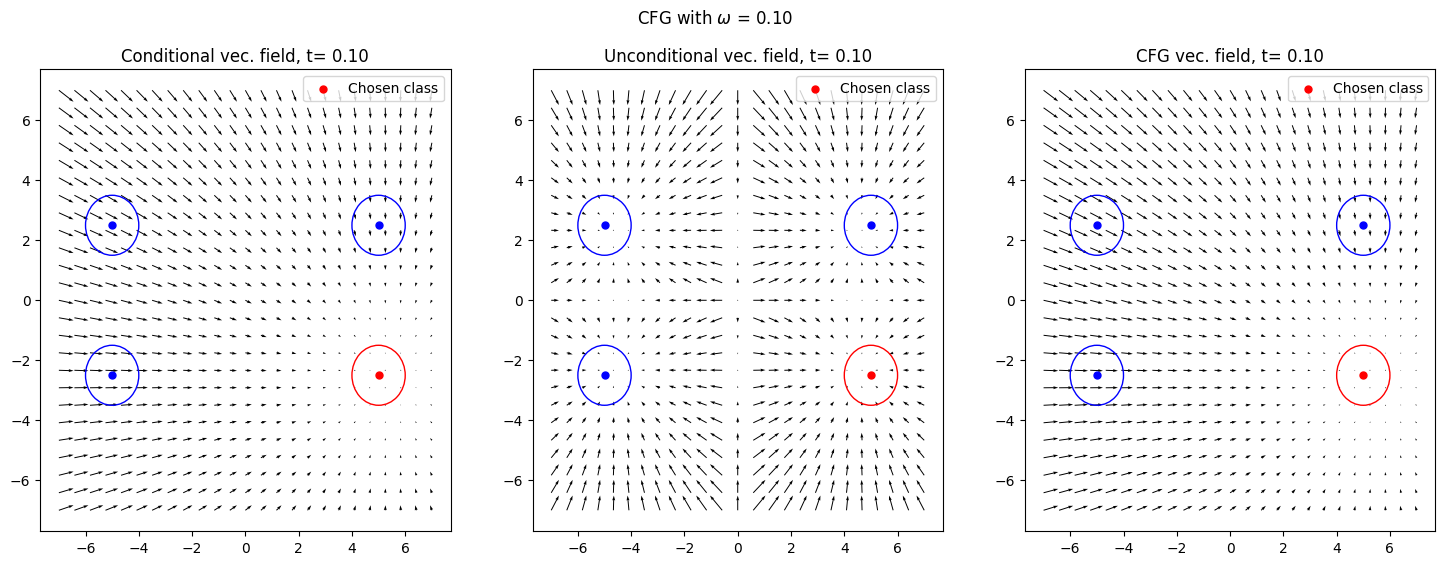

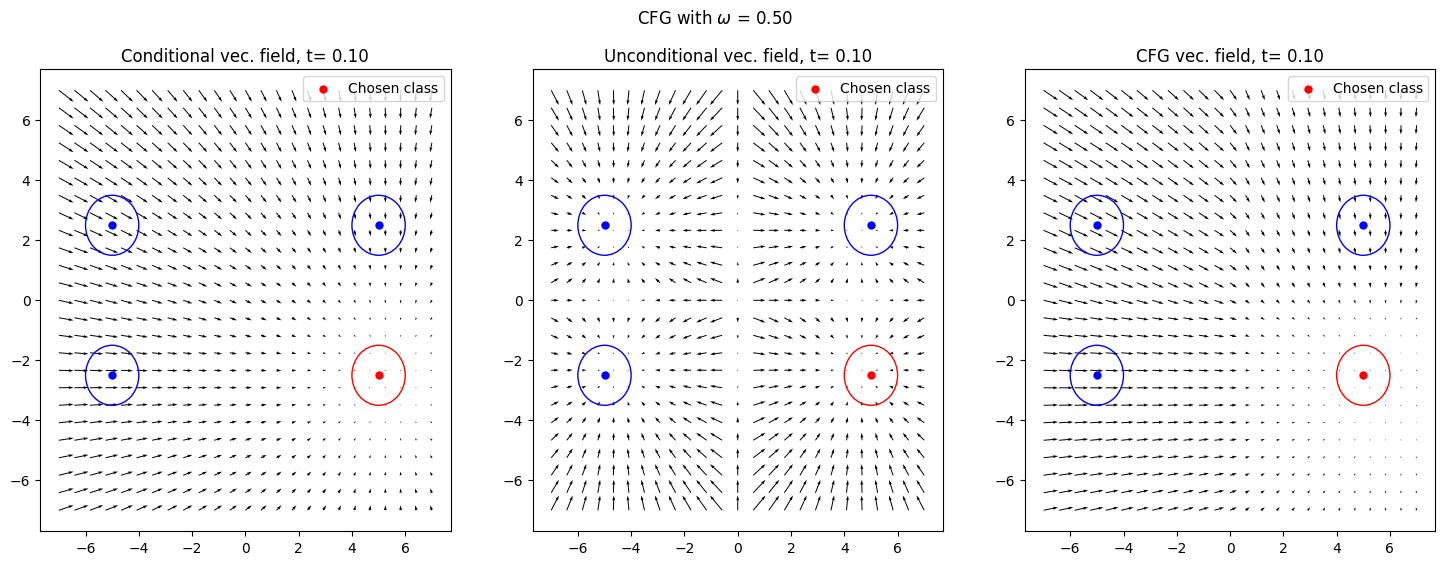

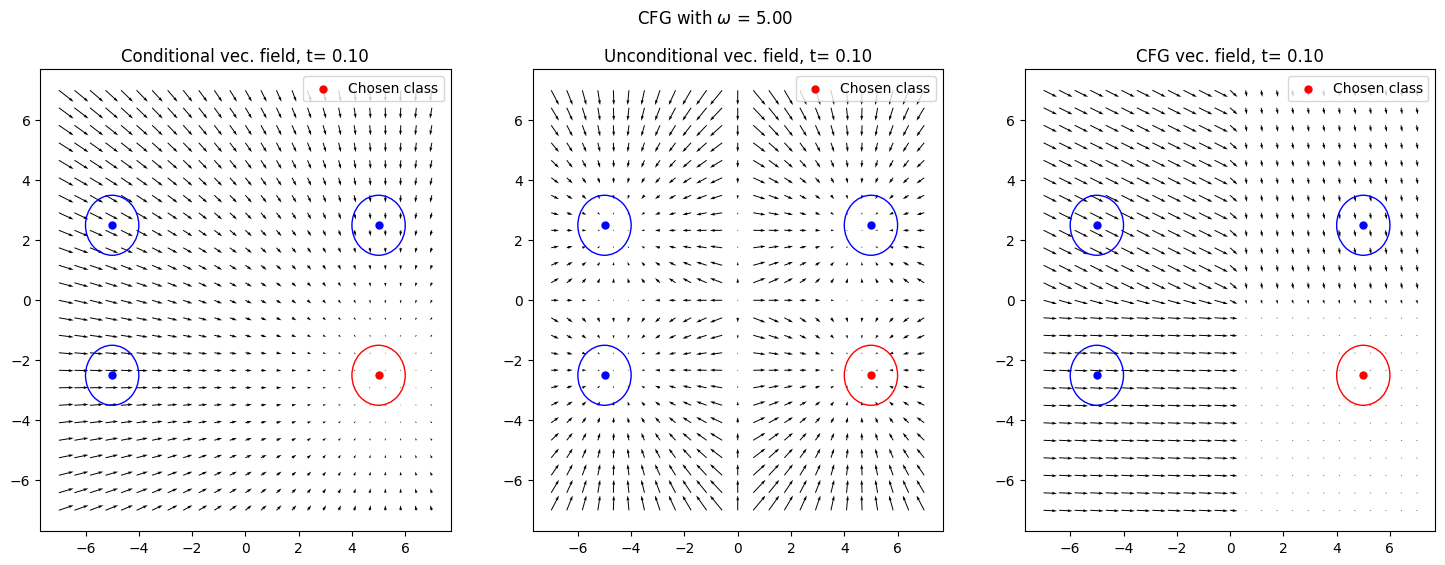

In [128]:
m1 = 5.
m2 = 2.5

t = torch.tensor([0.1])
dt = 0.01
sigma = torch.tensor([1.])
omega = .1
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, omega, n=25, min=-7, max=7, plot=True)
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, .5, n=25, min=-7, max=7, plot=True)
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, 5., n=25, min=-7, max=7, plot=True)

In [131]:
m1 = 5.
m2 = 2.5
sigma = torch.tensor([1.])
dt = 0.01
n = 25
omega = 5.
min_val = -7
max_val = 7
# Create a list to store images
images = []
# Generate 100 values of t from 0 to 1
t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc1, conc2, conc = get_all_three(m1, m2, t, dt, sigma, omega, n=n, min=min_val, max=max_val)
    # Plot the function
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
    for ax, c in zip(axes, [conc1, conc2, conc]):
        ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
        ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
        ax.scatter(m1, m2, color='b', s=25)
        ax.scatter(m1, -m2, color='r', s=25, label='Chosen class')
        ax.scatter(-m1, m2, color='b', s=25)
        ax.scatter(-m1, -m2, color='b', s=25)
        # Add contours of 2D Gaussian
        for mean in [np.array([5, 2.5]), np.array([-5, 2.5]), np.array([-5, -2.5])]:
            circle1 = plt.Circle(mean, 1., color='b', fill=False)
            ax.add_patch(circle1)
        circle1 = plt.Circle((5,-2.5), 1., color='r', fill=False)
        ax.add_patch(circle1)
        ax.legend()
    # Save the plot to a temporary file
    plt_path = f'plot_final/temp_{t_value:.2f}.png'
    fig.suptitle("CFG with $\omega$ = %.2f" % omega)
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('cfg_animation_w_'+str(omega)+'.gif', images, duration=0.05)

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


# New thing

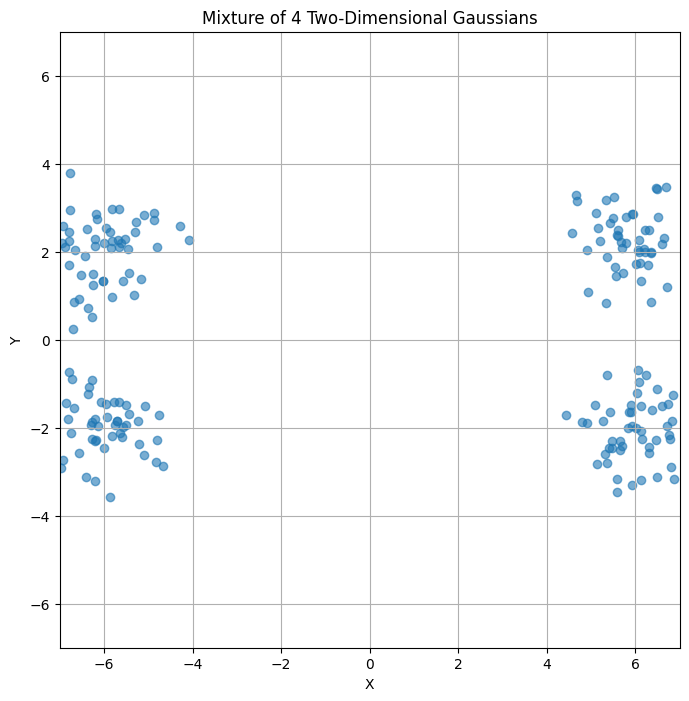

In [71]:
min_val, max_val = -7, 7
m1, m2 = 6., 2.
sigma = .5
means = torch.tensor([[m1, m2], [-m1, m2], [m1, -m2], [-m1, -m2]])
covariances = torch.tensor([[[1., 0.], [0., 1.]]] * 4) * sigma  # Shared covariance
weights = torch.tensor([0.25, 0.25, 0.25, 0.25])  # Equal weights
# Number of samples
num_samples = 200
# Sample from each Gaussian
samples = []
for mean, cov, weight in zip(means, covariances, weights):
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)
# Concatenate all samples
all_samples = torch.cat(samples)
# Plot the samples
plt.figure(figsize=(8, 8))
plt.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), alpha=0.6)
plt.title('Mixture of 4 Two-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.grid(True)
plt.show()


In [77]:
m2 = torch.tensor([0., .6])
m1 = torch.tensor([2,.0])
dt = torch.tensor(0.01)
sigma = torch.tensor([.5])
n = 25
min_val = -7
max_val = 7

t = 0.
finish_time = 4.
num_iter = 200

s_cfg = []
x_prev = all_samples

images_new = []
for t_ in tqdm(torch.linspace(t, finish_time, steps=num_iter)):
    t_ = torch.tensor([t_])
    x_cur = []
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*t_) + dt
        s_cfg = compute_S_i_t(x, t_, m1, m2, Gamma_t)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * s_cfg + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    plt.figure()
    plt.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(), alpha=0.6)
    plt.suptitle("Time is t: "+str(round(t_.item(),2)))
    plt_path = f'plot_fold2/temp_{t_.item():.2f}.png'
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.savefig(plt_path)
    plt.close()
    images_new.append(imageio.imread(plt_path))
    
    x_prev = x_cur

imageio.mimsave('sampling_animation_w_noise.gif', images_new, fps=10)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_3994553/1952620993.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


# New thing - reverse

In [86]:
# sample 200 samples from a 2D Gaussian with mean (0, 0) and covariance matrix [[1, 0], [0, 1]]
num_samples = 200
mean = torch.tensor([0., 0.])
cov = torch.tensor([[1., 0.], [0., 1.]])
distribution = torch.distributions.MultivariateNormal(mean, cov)
all_samples = distribution.sample((num_samples,))

In [87]:
m1 = torch.tensor([6.,0.])
m2 = torch.tensor([0., 2.5])
sigma = torch.tensor([.25])
min_val = -8
max_val = 8
dt = 0.005
finish_time = 3.

s_cfg = []
x_prev = all_samples
images_new = []


timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        s_cfg = compute_S_i_t(x, t_end-t, m1, m2, Gamma_t)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * s_cfg + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    
    
    plt.figure()
    plt.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(), alpha=0.6)
    # plt.scatter(*(m1+m2).numpy(), color='b', s=20)
    # plt.scatter(*(m1-m2).numpy(), color='r', s=20)
    # plt.scatter(*(-m1+m2).numpy(), color='r', s=20)
    # plt.scatter(*(-m1-m2).numpy(), color='r', s=20)
    
    plt.suptitle("Time is t: "+str(round((t_end-t).item(),2)))
    plt_path = f'plot_fold2/temp_{t.item():.2f}.png'
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.savefig(plt_path)
    plt.close()
    images_new.append(imageio.imread(plt_path))
    
    x_prev = x_cur

imageio.mimsave('sampling_animation_w_noise_reverse.gif', images_new, fps=20)

  0%|          | 2/601 [00:00<01:48,  5.51it/s]

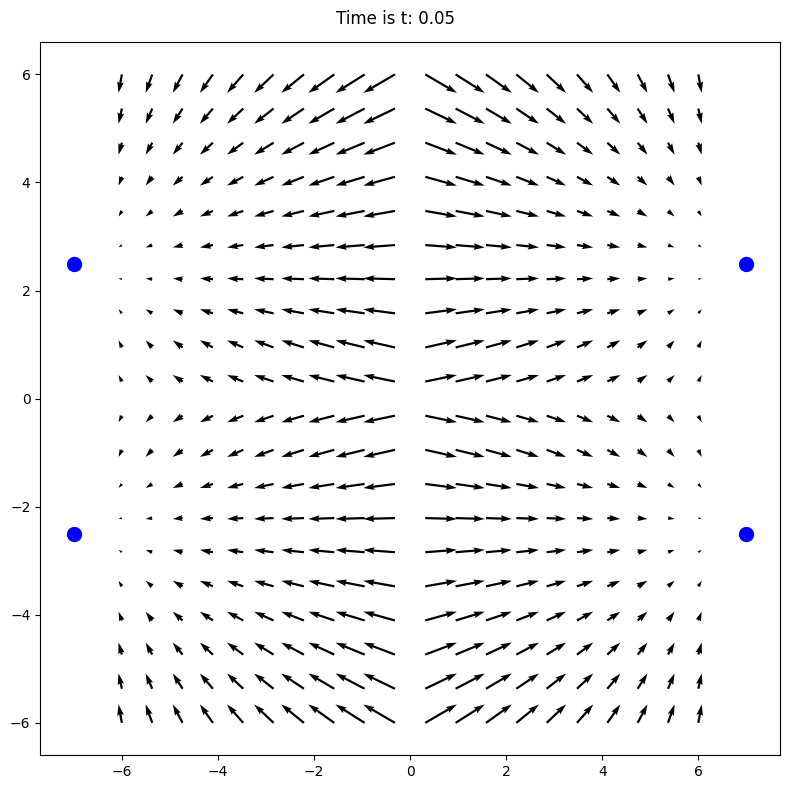

In [56]:
m1 = 7.
m2 = 2.5
t = torch.tensor([.05])
dt = 0.01
sigma = torch.tensor([1.])
inp, conc = get_vf(m1, m2, t, dt, sigma, n=20, min=-6, max=6, plot=True)


In [ ]:
# finish tidying up notebooks
# then do the analysis that marc sent u 
# tidy up the overleaf file